# 過学習の例

In [1]:
# 各種ライブラリをインポート
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

### データセットの作成

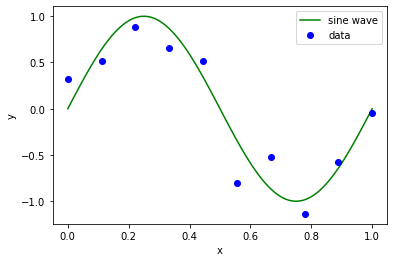

In [2]:
# サインカーブにノイズを加えたサンプルを生成
np.random.seed(seed=1)
x = np.linspace(0,1,10)
y = np.sin(2*np.pi*x) + np.random.normal(0,0.2,10)

# サインカーブ
x_sin = np.linspace(0, 1, 100)
y_sin = np.sin(2*np.pi*x_sin)

# 可視化
plt.plot(x_sin, y_sin, '-', color='g', label='sine wave')
plt.plot(x, y, 'o', color='b', label='data')
plt.xlabel("x")
plt.ylabel("y")
plt.legend(loc='best')
plt.show()

## 多項式回帰

In [3]:
x = x.reshape(-1,1)

# xを多項式に拡張
polys = []
nums = [1, 2, 3, 4, 5, 9]
for i in nums:
    poly_ = PolynomialFeatures(i)
    polys.append(poly_)

# 通常最小二乗法で学習
LRs = []
for poly_, num_ in zip(polys, nums):
    X_ = poly_.fit_transform(x).T[1:].T
    
    LR_ = LinearRegression().fit(X_, y)
    LRs.append(LR_)

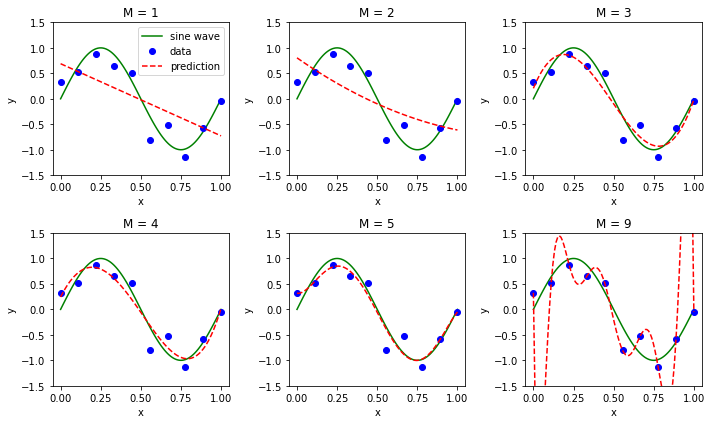

In [4]:
# 学習結果を可視化
fig, ax = plt.subplots(2, 3, figsize=(10,6))
axes = ax.ravel()

for ax_, poly_, LR_, num_ in zip(axes, polys, LRs, nums):
    
    X_sin = poly_.fit_transform(x_sin.reshape(-1,1)).T[1:].T
    y_ = LR_.predict(X_sin)
    
    ax_.plot(x_sin, y_sin, '-', color='g', label='sine wave')
    ax_.plot(x, y, 'o', color='b', label='data')
    
    ax_.plot(x_sin, y_, '--', color='r', label='prediction')
    
    ax_.set_xlabel('x')
    ax_.set_ylabel('y')
    
    ax_.set_ylim([-1.5,1.5])
    
    ax_.set_title('M = ' + str(num_))
    
    if num_==1: ax_.legend(loc='upper right')
    
fig.tight_layout()

In [5]:
# 係数を表示
index_w = ["w"+str(i) for i in range(nums[-1]+1)]

df_w = pd.DataFrame(index=index_w)
for LR_, num_ in zip(LRs, nums):
    weights = np.hstack((LR_.intercept_, LR_.coef_))
    df_ = pd.DataFrame(weights, columns=['M='+str(num_)], index=index_w[:num_+1])
    
    df_w = pd.concat([df_w, df_], axis=1)

pd.options.display.float_format = '{:.2f}'.format
df_w

,M=1,M=2,M=3,M=4,M=5,M=9
w0,0.69,0.80,0.21,0.24,0.32,0.32
w1,-1.42,-2.19,7.66,6.28,-0.47,-254.05
w2,nan,0.78,-25.19,-18.21,38.05,5954.13
w3,nan,nan,17.31,6.12,-152.90,-54168.85
w4,nan,nan,nan,5.60,187.87,257772.53
w5,nan,nan,nan,nan,-72.91,-712418.06
w6,nan,nan,nan,nan,nan,1183107.13
w7,nan,nan,nan,nan,nan,-1162608.56
w8,nan,nan,nan,nan,nan,622374.75
w9,nan,nan,nan,nan,nan,-139759.40


# 正則化最小二乗法の適用

In [6]:
# ライブラリインポート
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.model_selection import GridSearchCV

In [7]:
# 9次多項式回帰曲線に正則化項を導入
X_9 = polys[-1].fit_transform(x).T[1:].T

# ハイパーパラメータの探索範囲決定
param_grid = {'alpha': [10.**(n) for n in np.arange(-3,2,1)]}
linear_models = [Ridge(max_iter=100000), Lasso(max_iter=100000)]

# グリッドサーチによりハイパーパラメータ最適化
opt_alphas = []
for j in range(len(linear_models)):
    grid_search = GridSearchCV(linear_models[j], param_grid, cv=2, return_train_score=True)
    grid_search.fit(X_9, y)

    opt_alphas.append(grid_search.best_params_['alpha'])

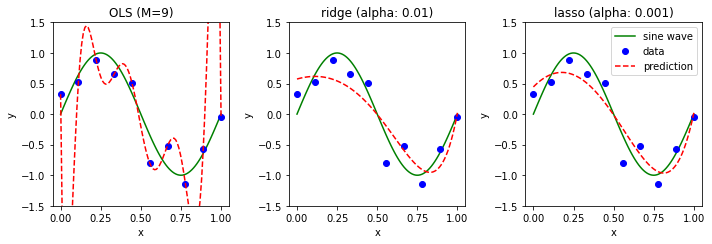

In [8]:
# 最適なハイパーパラメータで学習
ridge = Ridge(alpha=opt_alphas[0],max_iter=100000).fit(X_9, y)
lasso = Lasso(alpha=opt_alphas[1],max_iter=100000).fit(X_9, y)

# 学習結果の図示
regs = [LRs[-1], ridge, lasso]
names = ['OLS (M=9)', 'ridge', 'lasso']

X_sin = polys[-1].fit_transform(x_sin.reshape(-1,1)).T[1:].T

fig, ax = plt.subplots(1, 3, figsize=(10,3.5))

for i, reg_ in enumerate(regs):
    y_ = reg_.predict(X_sin)
    
    ax[i].plot(x_sin, y_sin, '-', color='g', label='sine wave')
    ax[i].plot(x, y, 'o', color='b', label='data')
    
    ax[i].plot(x_sin, y_, '--', color='r', label='prediction')
    
    ax[i].set_xlabel('x')
    ax[i].set_ylabel('y')
    
    ax[i].set_ylim([-1.5,1.5])
    
    if i == 0:
        name_ = names[0]
        
    else:
        name_ = names[i] + " (alpha: " + str(opt_alphas[i-1]) + ")"
    
    ax[i].set_title(name_)
    
    if i==2: ax[i].legend(loc='upper right')
    
fig.tight_layout()

In [9]:
# 係数の表示
df_w_regularized = pd.DataFrame(index=index_w)
for i in range(3):
    weights = np.hstack((regs[i].intercept_, regs[i].coef_))
    df_w_regularized[names[i]] = weights

pd.options.display.float_format = '{:.4f}'.format
df_w_regularized

,OLS (M=9),ridge,lasso
w0,0.3249,0.5736,0.4444
w1,-254.0475,0.7424,2.6888
w2,5954.1292,-3.0046,-7.6257
w3,-54168.8450,-1.8439,-0.0000
w4,257772.5254,-0.3024,0.0000
w5,-712418.0575,0.6704,2.1443
w6,1183107.1250,1.0621,2.3690
w7,-1162608.5621,1.0392,0.0000
w8,622374.7536,0.7569,0.0000
w9,-139759.3957,0.3271,-0.0000


# 幾何学的解釈のための図の作成

In [10]:
from mpl_toolkits.mplot3d import Axes3D

In [11]:
# グラフ範囲の表示
w = np.arange(-4, 4.1, 0.1)
w0, w1 = np.meshgrid(w, w)

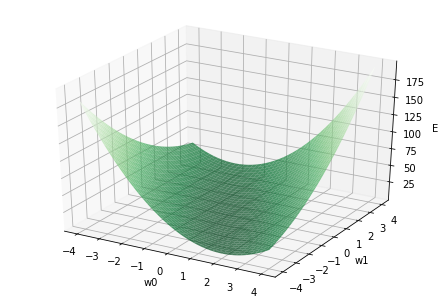

In [12]:
# 二乗和誤差項計算
E_sq = np.empty(w0.shape)
for i in range(w0.shape[1]):
    E_sq[i] = (0.5*(y.reshape(10,-1)-x*w1[i]-w0[i])**2).sum(axis=0)

# 図の初期化
fig = plt.figure()
ax = Axes3D(fig)

# 軸ラベルの指定
ax.set_xlabel("w0")
ax.set_ylabel("w1")
ax.set_zlabel("E")

# 3次元曲面の描画
ax.plot_surface(w0, w1, E_sq, cmap='Greens_r', alpha=0.7)

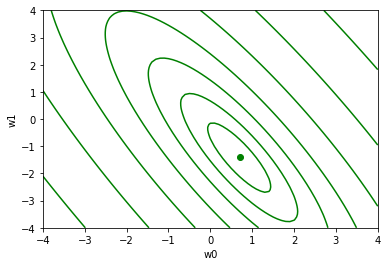

In [13]:
# 二乗和誤差項計算
E_sq = np.empty(w0.shape)
for i in range(w0.shape[1]):
    E_sq[i] = (0.5*(y.reshape(10,-1)-x*w1[i]-w0[i])**2).sum(axis=0)

# 最小値計算
argmin = np.where(E_sq==E_sq.min())
w0_min_sq = w0[argmin[0],argmin[1]]
w1_min_sq = w1[argmin[0],argmin[1]]

# コンター図の設定
plt.contour(w0, w1, E_sq, colors='g', levels=[2.**(i+1) for i in range(7)])
plt.plot(w0_min_sq, w1_min_sq, 'o', c='g')

# 軸ラベルの指定
plt.xlabel("w0")
plt.ylabel("w1")

plt.show()

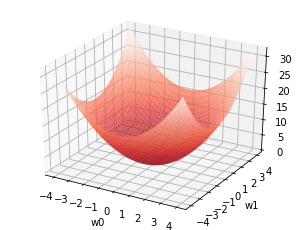

In [14]:
# 正則化項 ridge
E_reg_2 = w0**2 + w1**2

# 図の初期化
fig = plt.figure(figsize=(4,3))
ax = Axes3D(fig)

# 軸ラベルの指定
ax.set_xlabel("w0")
ax.set_ylabel("w1")
ax.set_zlabel("E")

# 3次元曲面の描画
ax.plot_surface(w0, w1, E_reg_2, cmap='Reds_r', alpha=0.7)

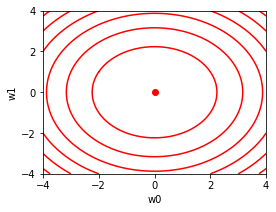

In [15]:
# 正則化項 ridge
E_reg_2 = w0**2 + w1**2

#
fig = plt.figure(figsize=(4,3))

# 最小値
argmin = np.where(E_reg_2==E_reg_2.min())
w0_min_r2 = w0[argmin[0],argmin[1]]
w1_min_r2 = w1[argmin[0],argmin[1]]

# コンター図の設定
plt.contour(w0, w1, E_reg_2, colors='r', levels=7)
plt.plot(w0_min_r2, w1_min_r2, 'o', c='r')

# 軸ラベルの指定
plt.xlabel("w0")
plt.ylabel("w1")

plt.show()

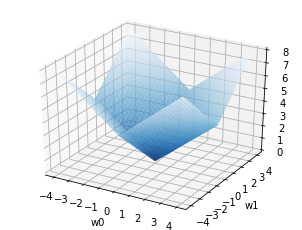

In [16]:
# 正則化項 lasso
E_reg_1 = abs(w0) + abs(w1)

# 図の初期化
fig = plt.figure(figsize=(4,3))
ax = Axes3D(fig)

# 軸ラベルの指定
ax.set_xlabel("w0")
ax.set_ylabel("w1")
ax.set_zlabel("E")

# 3次元曲面の描画
ax.plot_surface(w0, w1, E_reg_1, cmap='Blues_r', alpha=0.7)


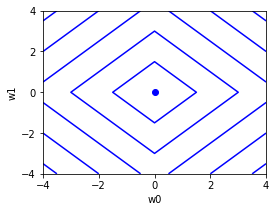

In [17]:
# 正則化項 lasso
E_reg_1 = abs(w0) + abs(w1)

#
fig = plt.figure(figsize=(4,3))

# 最小値
argmin = np.where(E_reg_1==E_reg_1.min())
w0_min_r1 = w0[argmin[0],argmin[1]]
w1_min_r1 = w1[argmin[0],argmin[1]]

# コンター図の設定
plt.contour(w0, w1, E_reg_1, colors='b', levels=7)
plt.plot(w0_min_r1, w1_min_r1, 'o', c='b')

# 軸ラベルの指定
plt.xlabel("w0")
plt.ylabel("w1")

plt.show()